# Object Detection in a maritime context

## Introduction

In this lab we want to go deeper into the comprehension and the use of object detection architectures by training maritime object detectors. We will start by training a Faster R-CNN object detector on a maritime Pascal VOC subset. Then we will redefine our need to retrain the model in a more efficient fashion. Then we'll analyse the performance of the model using metrics seen in class.

## Objectives
- Learn to use an object detector in pytorch and evaluate it.
- Select data and train a detector to meet an industry requirement.

## Getting started

Load all the necessary packages before starting.

In [1]:
# import torch packages
import pandas as pd 
import torch
import torch.nn as nn
import os
import time
from pathlib import Path
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files, drive

## Exercise 1: What is the challenge ?

For the Unmanned Surface Vehicle (USV) we want to be able to detect all surrounding floating objects and classify them into one of the following categories.

0. boat
1. buoy
2. sail
3. person
4. kayak
5. motor_sail
6. ferry
7. vessel
8. zodiac
9. fishing_boat
10. OFNI
11. kite
12. windsurf
13. surfboard

For that purpose Eca Robotics has downloaded [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) open dataset, filter only maritime images and reannotate them with interesting classes. Indeed Pascal VOC dataset only contains 20 categories and we kept images containing boat objects.

**Can you train a maritime object detector with that dataset ?**

Load the data and create stats on the classes to get a sense of the dataset.

In [2]:
!gdown 1ik0v3VJosH9E_UX62nGxl-hi75t36knJ

Downloading...
From: https://drive.google.com/uc?id=1ik0v3VJosH9E_UX62nGxl-hi75t36knJ
To: /content/maritime_object_detection.tar
100% 59.6M/59.6M [00:01<00:00, 35.3MB/s]


In [3]:
!tar -xf maritime_object_detection.tar

In [4]:
data_path = 'pascal_voc/train/'

# Create annotations dictionnary
anno_dict = {
    0: "boat",
    1: "buoy",
    2: "sail",
    3: "person",
    4: "kayak",
    5: "motor_sail",
    6: "ferry",
    7: "vessel",
    8: "zodiac",
    9: "fishing_boat",
    10: "OFNI",
    11: "kite",
    12: "windsurf",
    13: "surfboard"
}
for class_id, class_name in anno_dict.items():
    print(class_id, class_name)


0 boat
1 buoy
2 sail
3 person
4 kayak
5 motor_sail
6 ferry
7 vessel
8 zodiac
9 fishing_boat
10 OFNI
11 kite
12 windsurf
13 surfboard


We show an image to see the nature of the images.

In [5]:
from PIL import Image
Image.open(data_path + '2007_000061.jpg')

a=Image.open(data_path + '2007_000061.jpg')
# print (a.size)

! cat pascal_voc/train/labels.txt

boat
buoy
sail
person
kayak
motor_sail
ferry
vessel
zodiac
fishing_boat
OFNI
kite
windsurf
surfboard

We want to count the number of occurences of each class in the 500+ files we have at our disposal.



```
TODO
1. read all txt files and iterate over them - Path and glob function,
2. filter labels.txt file,
3. using pandas to read column 0 and append it to the classes list,
4. concat the list into a pandas dataframe,
5. return the count using value_counts function
```

In [6]:
# Get annotations from txt files
def count_objects(data_path):
    """
    Function reading all yolo format txt files and returning number of objects by class

    <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    <object-class> - integer number of object from 0 to (classes-1)
    <XCenterRelative> <YCenterRelative> - center of the bounding box [0,1]
    <WidthRelative> <HeightRelative> - width and height [0,1]
    """
    # Initialize an empty list to store the class labels
    classes = []
    # Use pathlib to access the directory specified by data_path
    dir = Path(data_path)
    # Use glob to get all the txt files in the directory
    txt_files = dir.glob("*.txt")
    # Iterate through the txt files and read the first column using pandas
    for file in txt_files:
        df = pd.read_csv(file, header=None, delimiter=' ')
        if file.name !='labels.txt':
            classes.append(df[0])
    # Concatenate the list of classes into a single DataFrame
    count_df = pd.concat(classes)
    # Get the count of each class and return the result
    counts = count_df.value_counts()
    return counts

In [7]:
count_df = count_objects(data_path)
# If assert launch an error there is an error in your code, else it is OK.
assert len(count_df) == 14
count_df

3     572
0     416
4     170
2     165
1     149
5     139
6     113
7      66
9      55
8      37
10      8
12      3
11      2
13      1
Name: 0, dtype: int64

To improve readability replace index by class names using the dictionnary anno_dict.

```
TODO
Replace index by class names with one command
```

Hint : Use pandas.rename function.

In [8]:
### BEGIN SOLUTION
count_df =count_df.rename(anno_dict)
### END SOLUTION
assert count_df['sail'] == 165
count_df

person          572
boat            416
kayak           170
sail            165
buoy            149
motor_sail      139
ferry           113
vessel           66
fishing_boat     55
zodiac           37
OFNI              8
windsurf          3
kite              2
surfboard         1
Name: 0, dtype: int64

To improve the effectiveness of the TP we use a small dataset, which is still long to train. Futhermore the dataset is unbalanced, which is a difficulty to train a robust detector. 

In industrial applications several thousands of annotations by class are needed to obtain an acceptable performance. We'll keep that in mind when analysing results.

## Exercise 2: Code a dataloader

To exploit the images and their annotations, we need to write a dataloader in order to iterate through the images in the Pytorch format.

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. **Then we need to modify class 0 - boat, in order to make a difference from the background. We will replace 0 by 14.**

```
TODO
Implement __getitem__ function by following comments in the code
```

In [9]:
class VocDataset(torch.utils.data.Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    # load all image files, sorting them to ensure that they are aligned
    self.imgs = list(sorted(Path(root).glob('*.jpg')))
    self.bboxes = list(sorted(Path(root).glob('*.txt')))[:-1] # ignore labels.txt

  def __getitem__(self, idx):

    # BEGIN SOLUTION
    # get image and bounding boxes paths
    img_path = self.imgs[idx]
    bbox_path =  self.bboxes[idx]
    img = Image.open(img_path).convert("RGB")
    # get width and height
    width, height = img.size
    # get bounding boxes
    bbox_df = pd.read_csv(bbox_path, header=None, sep=' ')

    # get bounding box coordinates
    # YOLO format reminder :
    # <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    boxes = []
    for index, row in bbox_df.iterrows():
      xmin = (row[1] - row[3]/2)*width
      xmax = (row[1] + row[3]/2)*width
      ymin = (row[2] - row[4]/2)*height
      ymax =(row[2] + row[4]/2)*height 
      if xmin < xmax and ymin < ymax:
        boxes.append([xmin, ymin, xmax, ymax])

    # convert everything into a torch.Tensor
    boxes = torch.Tensor(boxes)
    # replace label 0 by 14
    labels = bbox_df[0].replace(0, 14)
    # convert labels to a torch.Tensor
    labels = torch.as_tensor(labels, dtype=torch.int64)

    # get image id
    image_id = torch.Tensor([idx])
    # compute area of the bounding boxes
    area = (boxes[:,2] - boxes[:,0])*(boxes[:,3] - boxes[:,1])  
    # suppose all instances are not crowd
    iscrowd = torch.zeros((len(bbox_df),), dtype=torch.int64)

    # populate target dictionnary
    target = {}
    target["boxes"] = boxes
    target["labels"] =  labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    ### END SOLUTION

    # image transformation
    if self.transform is not None:
      img, target = self.transform(img, target)

    return img, target


  def __len__(self):
    return len(self.imgs)

Let now get the result tuple for the first image and plot it with ground truth annotations to see if the data seems correctly read.

In [10]:
dataset = VocDataset(data_path)
assert torch.equal(dataset[2][1]['area'], torch.tensor([22363.4668]))
assert torch.equal(dataset[1][1]['labels'], torch.tensor([14, 5, 14]))
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x333 at 0x7F34F3CD0040>,
 {'boxes': tensor([[274.0000,  10.9998, 437.0000, 278.9999],
          [187.3420, 214.0001, 281.0000, 252.0001]]),
  'labels': tensor([5, 6]),
  'image_id': tensor([0.]),
  'area': tensor([43684.0117,  3559.0000]),
  'iscrowd': tensor([0, 0])})

In [11]:
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

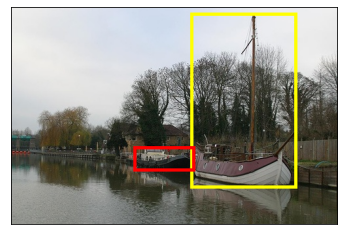

In [12]:
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

img1_int = read_image(data_path + '/2007_000061.jpg')
colors = ["yellow", "red"]
result = draw_bounding_boxes(img1_int, dataset[0][1]['boxes'], colors=colors, width=5)
show(result)

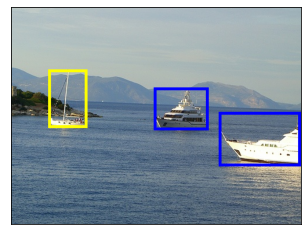

In [13]:
img2_int = read_image(data_path + '/2007_000241.jpg')
colors = ["blue", "yellow", "blue"]
result = draw_bounding_boxes(img2_int, dataset[1][1]['boxes'], colors=colors, width=5)
show(result)

The dataloader seems to do the job. If you are curious about the dataset you can plot other images, or create a grib with several ones.

## Exercise 3: Define a model

In this tutorial, we will be using faster R-CNN as described in class. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://www.researchgate.net/profile/Zhipeng-Deng-2/publication/324903264/figure/fig2/AS:640145124499471@1529633899620/The-architecture-of-Faster-R-CNN.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

We are in the first case to use all the power of a pretrained model. We'll load Faster R-CNN with pretrained weights before retraining it on the images we have. By that means we accelerate the training of the model.

```
TODO
1. load a pretrained fasterrcnn_resnet50_fpn
2. get number of input features for the classifier
3. replace the pre-trained head with a new one
```

In [14]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

def get_detection_model(num_classes=15):

  ### BEGIN SOLUTION

  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

  ### END SOLUTION

  return model

In [15]:
model = get_detection_model()
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Exercise 4: Preparing training loop

In references/detection/, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use references/detection/engine.py, references/detection/utils.py and references/detection/transforms.py.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [16]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 289636, done.
remote: Counting objects: 100% (10762/10762), done.
remote: Compressing objects: 100% (699/699), done.
remote: Total 289636 (delta 10110), reused 10637 (delta 10039), pack-reused 278874
Receiving objects: 100% (289636/289636), 584.89 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (265212/265212), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


### Data augmentation

To go deeper into the training process we want to do data augmentation by applying random transformations to the images. It allows the model to train longer without overfitting and augment programmatically the dataset size and the genericity of the model.

You can find the reference of the transformations here: https://pytorch.org/vision/stable/transforms.html

In [17]:
import transforms as T

def get_transform(train):
    transform = []
    # converts the image, a PIL image, into a PyTorch Tensor
    # transform.append(transforms.ToTensor())
    transform.append(T.ToTensor())
    if train:

      ### BEGIN SOLUTION

      # during training randomly horizontal flip the training images - proba 0.5
      transform.append(T.RandomHorizontalFlip(0.5))
      ## END SOLUTION

    return T.Compose(transform)

### Testing forward() method

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

```
TODO
Follow the comments on the next cell
```

In [18]:
import utils

### BEGIN SOLUTION

# get model and dataset with augmentations
model = get_detection_model()
dataset =  VocDataset(data_path, get_transform(train=True))

# create dataloader with torch.utils.data.DataLoader
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# For training
# get next batch images + targets by iterating on the data_loader
images, targets = next(iter(data_loader))
# Convert images and targets into the desired format by the model
# Hint : use list comprehension
images =   list([img for img in images]) # look expected images values https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
targets =   [{k: v for k, v in t.items()} for t in targets] # look expected targets values https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
output = model(images, targets)   # Returns losses and detections

### END SOLUTION

In [19]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) # Returns predictions
predictions

[{'boxes': tensor([[ 82.1412,   0.0000, 397.1208, 181.9945],
          [ 68.9907, 118.6335, 399.8573, 300.0000],
          [ 70.5854,  65.9140,  74.0160,  70.6960],
          [167.0256, 101.6013, 169.9874, 105.0588],
          [168.0648, 101.9351, 171.3041, 105.8150],
          [173.7889,  96.4983, 176.9655,  99.6114],
          [ 71.5613,  64.8036,  74.7201,  69.6867],
          [169.1796,  97.7750, 172.5001, 100.7626],
          [165.6006, 101.2645, 168.3766, 104.4184],
          [166.9864, 102.9750, 169.9644, 106.7453],
          [169.3425, 102.0854, 172.3994, 105.7296],
          [137.6156, 100.6809, 140.9619, 103.8402],
          [174.3553, 102.5986, 177.1814, 105.8126],
          [192.7075,  80.1039, 400.0000, 265.3915],
          [173.9957, 101.0666, 176.8109, 104.1952],
          [172.8177,  95.7881, 176.2662,  99.0228],
          [170.7115, 101.6153, 173.9027, 105.2491],
          [139.3111, 136.9662, 142.8592, 140.9084],
          [173.8044,  95.5039, 177.2776,  98.7141],
   

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

## Exercise 5: Putting everything together

We now have the dataset class, the model, the data transform and a hint about the dataloader. Let's instantiate them to launch a full training process.

First we want to create train/test split for the training and apply dataloaders to each one.

In [20]:
from engine import train_one_epoch, evaluate

### BEGIN SOLUTION

# use our dataset and defined transformations
dataset = VocDataset(data_path, get_transform(train=True))
dataset_test = VocDataset(data_path, get_transform(train=False))

# split the dataset in train and test set with torch.utils.data.Subset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset,indices[:int(len(indices)*0.8)] )
dataset_test = torch.utils.data.Subset(dataset,indices[int(len(indices)*0.8):] )

from torch.utils.data import DataLoader
# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
 )# use a batch_size of 4, 2 workers and the shuffle option

data_loader_test = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
 )  # use a batch_size of 2, 2 workers and disable the shuffle option

### END SOLUTION

Then, instantiate the model and the optimizer.

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 14 classes but bg class is set to 0
num_classes = 15

### BEGIN SOLUTION

# get the model using our helper function
model = get_detection_model()
model = model.to(device)
# move model to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# construct an optimizer SGD with lr=0.005, momentum=0.9 and weight_decay=0.0005
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr = 0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### END SOLUTION

And now let's train the model for 3 epochs, evaluating at the end of every epoch.

It's time for you to take a 20 min break during the training.

In [22]:
# let's train it for 3 epochs
num_epochs = 3

### BEGIN SOLUTION

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, 10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

### END SOLUTION

Epoch: [0]  [  0/220]  eta: 0:27:50  lr: 0.000028  loss: 2.8806 (2.8806)  loss_classifier: 2.7214 (2.7214)  loss_box_reg: 0.1405 (0.1405)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 7.5912  data: 0.1647  max mem: 2787
Epoch: [0]  [ 10/220]  eta: 0:04:15  lr: 0.000256  loss: 2.8940 (2.9728)  loss_classifier: 2.6690 (2.6991)  loss_box_reg: 0.2109 (0.2362)  loss_objectness: 0.0112 (0.0183)  loss_rpn_box_reg: 0.0108 (0.0192)  time: 1.2150  data: 0.0227  max mem: 3530
Epoch: [0]  [ 20/220]  eta: 0:02:59  lr: 0.000484  loss: 2.8231 (2.8102)  loss_classifier: 2.4122 (2.4384)  loss_box_reg: 0.2731 (0.3275)  loss_objectness: 0.0132 (0.0208)  loss_rpn_box_reg: 0.0147 (0.0234)  time: 0.5634  data: 0.0079  max mem: 3530
Epoch: [0]  [ 30/220]  eta: 0:02:29  lr: 0.000712  loss: 2.0829 (2.4344)  loss_classifier: 1.7146 (2.0655)  loss_box_reg: 0.3044 (0.3197)  loss_objectness: 0.0132 (0.0251)  loss_rpn_box_reg: 0.0197 (0.0240)  time: 0.5497  data: 0.0073  max mem: 3530


At each epoch, an evaluation process is launched to monitor the training. For the last epoch what AP do you get ? 

### Checkpoints

We may now save the model and the state of optimizers and learning rate schedulers in order to continue training from where we left of. This is known as checkpointing.

In [23]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            }, 'checkpoint.pt')

We can then re-create model, optimizer and lr_scheduler from scratch and simply load their state from the checkpoint file we have just saved.

In case you have not been able to train your model during the break or have lost your model for some reason we provide you a checkpoint from this link which you can download and upload it to Colab to continue with the lab: [https://drive.google.com/file/d/1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ/view?usp=sharing](https://drive.google.com/file/d/1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ/view?usp=sharing)

We may download it directly to Colab by doing: 

```
gdown --id 1u-OA-XUGE3JA3czarnFInHLw-QQ22hFQ
```

In [24]:
model = get_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
epoch = checkpoint['epoch']

model.eval()
model.train()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Exercise 6: Visualize the result on an image

Computer Vision has the great advantage to be visual. Le's check the prediction on a an image.

In [25]:
from torchvision.transforms.functional import convert_image_dtype

# Batch images
batch_int = torch.stack([img1_int])
batch = convert_image_dtype(batch_int, dtype=torch.float).to(device)

model = model.eval()

# Print images with model prediction
outputs = model(batch)
print(outputs)

[{'boxes': tensor([[191.3784, 213.9927, 280.2482, 251.4216],
        [270.8130, 180.3071, 437.6235, 276.6364],
        [270.2291,   5.3385, 440.4399, 277.3130],
        [300.0168,   1.3479, 427.9470, 328.4692],
        [428.9918, 234.8638, 499.9006, 274.5449],
        [245.8085,   8.3240, 487.3215, 265.4313],
        [285.8304, 109.2048, 435.1930, 278.7835],
        [196.5838, 212.9758, 275.5949, 257.4971],
        [238.1250, 215.8428, 244.4433, 228.1503],
        [267.9829,  82.7619, 436.6755, 279.0941],
        [268.6748, 180.8580, 444.4743, 267.4149],
        [191.8987, 221.7196, 277.2064, 251.6487],
        [211.0287, 228.2299, 277.7337, 251.1899],
        [274.2420, 197.6874, 417.6805, 278.3164],
        [186.6966, 200.0584, 277.6661, 259.5903],
        [257.9862, 106.8003, 443.8497, 282.9889],
        [250.2951, 154.5227, 452.8402, 272.9220],
        [430.1862, 236.4828, 500.0000, 273.8047],
        [195.1799, 211.4295, 272.1029, 259.2662],
        [277.4286, 169.2501, 477.6973, 

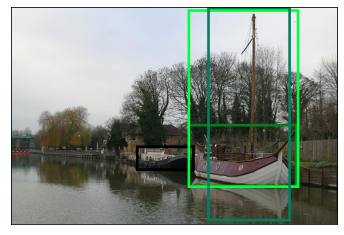

In [26]:
# Select minimum threshold for keeping bbox
score_threshold = .3
# Show boxes
imgs_with_boxes = [
    draw_bounding_boxes(img_int,
                        boxes=output['boxes'][output['scores'] > score_threshold],
                        width=4)
    for img_int, output in zip(batch_int, outputs)
]
show(imgs_with_boxes)

Play with the score threshold. 

Can you select a good trade-off threshold ? 

Can you think of a technique to remove the duplicated bounding boxes ?

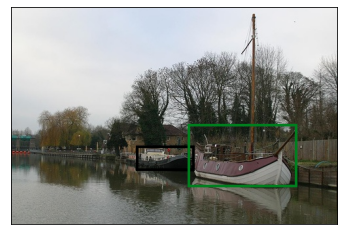

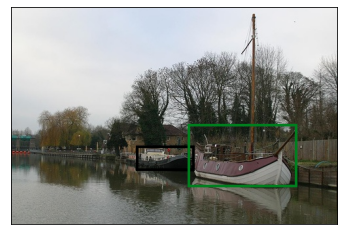

In [27]:
# Import the torchvision
from torchvision import ops

# Define a function 'show_filtered_images' that takes in 3 parameters - 'batch_int', 'outputs', and 'score_threshold'
def show_filtered_images(batch_int, outputs, score_threshold):
  # Create a list 'imgs_with_boxes' that contains the result of 'draw_bounding_boxes' for each image in 'batch_int'
  imgs_with_boxes = [
      draw_bounding_boxes(img_int,
                          boxes=output['boxes'][output['scores'] > score_threshold],
                          width=4)
      for img_int, output in zip(batch_int, outputs)
  ]
  # Call the 'show' function to display the images
  show(imgs_with_boxes)

# Define a function 'show_nms_boxes' that takes in 3 parameters - 'batch_int', 'outputs', and 'score_threshold'
def show_nms_boxes(batch_int, outputs, score_threshold):
  # Loop over each image and output in 'batch_int' and 'outputs'
  for img_int, output in zip(batch_int, outputs):
    idxs = output['scores'] > score_threshold
    # Apply the non-maximum suppression
    boxes = torchvision.ops.batched_nms(boxes = output['boxes'][idxs], 
                              scores = output['scores'][idxs], 
                              idxs = output['labels'][idxs], 
                              iou_threshold = 0.6)
    # Convert the 'boxes' tensor to a list
    boxes_idxes = boxes.tolist()
    # Create a list 'imgs_with_boxes' that contains the result of 'draw_bounding_boxes' for each image in 'batch_int'
    imgs_with_boxes = [
        draw_bounding_boxes(img_int,
                          boxes=output['boxes'][boxes_idxes],
                          width=4)
    ]
  show(imgs_with_boxes)

# Set a threshold of 0.5
score_threshold = 0.5

# Call the 'show_filtered_images'
show_filtered_images(batch_int, outputs, score_threshold)

# Call the 'show_nms_boxes"
show_nms_boxes(batch_int, outputs, score_threshold)


In [28]:
for img_int, output in zip(batch_int, outputs):
  toto = ops.nms(output['boxes'], output['scores'], iou_threshold=0.5)
  print(toto)

tensor([ 0,  1,  2,  4,  8, 12, 20, 22], device='cuda:0')


In [29]:
for img_int, output in zip(batch_int, outputs):
  print(output['boxes'][toto])

tensor([[191.3784, 213.9927, 280.2482, 251.4216],
        [270.8130, 180.3071, 437.6235, 276.6364],
        [270.2291,   5.3385, 440.4399, 277.3130],
        [428.9918, 234.8638, 499.9006, 274.5449],
        [238.1250, 215.8428, 244.4433, 228.1503],
        [211.0287, 228.2299, 277.7337, 251.1899],
        [189.6143, 184.8827, 281.3752, 264.4959],
        [194.8195, 214.0581, 258.3665, 239.3128]], device='cuda:0',
       grad_fn=<IndexBackward0>)


## Exercise 7: Create a MVP (Minimum Viable Product)

To cope with the small unbalanced dataset we have, two solutions are available

* Get more data on the internet or at sea, but we don't have time to search and annotate new data. Annotation is a faily time-consuming process. [Make a try](https://www.makesense.ai/)
* Merge classes to simplify the problem and balance the data.

For example in our case 14 categories is detailed. Indeed we want to be able to separate

* small_vessel -> [boat, motor_sail, zodiac]
* big_vessel -> [ferry, vessel, fishing_boat]
* sail_vessel -> [sail, windsurf, kite]
* human_powered_vessel -> [kayak, surfboard]
* person
* other -> [buoy, OFNI]

```
TODO 
1. Modify the dictionnary of annotations.
2. Modify the dataLoader class to implement that merging process.
```

In [30]:
# New maritime dictionnary for MVP
new_maritime_dict = {
    0: "small_vessel",
    1: "big_vessel",
    2: "sail_vessel",
    3: "human_powered_vessel",
    4: "person",
    5: "other"
}

In [31]:
# Create a dictionnary to convert labels
merging_dict = {
    0: 0,
    1: 5,
    2: 2,
    3: 4,
    4: 3,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 5,
    11: 2,
    12: 2,
    13: 3
}

Recreate count of all images to recreate class balance. You can use the function from exercise 1.

In [32]:
# Get annotations from txt files
def mvp_count_objects(data_path):
  """
  Function reading all txt files from a yolo format and returning number of objects by class

  <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
  <object-class> - integer number of object from 0 to (classes-1)
  <XCenterRelative> <YCenterRelative> - center of the bounding box [0,1]
  <WidthRelative> <HeightRelative> - width and height [0,1]
  """
  classes = []

  ### BEGIN SOLUTION
  return count_objects(data_path)
  ### END SOLUTION

In [33]:
# apply count and rename classes
### BEGIN SOLUTION
count_df =  mvp_count_objects(data_path)
def mvp_labels(df):
  df = df.rename(merging_dict)
  df = df.groupby(level=0).sum()
  df = df.rename(new_maritime_dict)
  return df
### END SOLUTION
count_df = mvp_labels(count_df)

assert count_df['sail_vessel'] == 170
count_df

small_vessel            592
big_vessel              234
sail_vessel             170
human_powered_vessel    171
person                  572
other                   157
Name: 0, dtype: int64

Now that we can see that the dataset is more balanced, let's modify the dataloader to modify the class during the loading of the data.

In [34]:
class VocDataset(torch.utils.data.Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    # load all image files, sorting them to ensure that they are aligned
    self.imgs = list(sorted(Path(root).glob('*.jpg')))
    self.bboxes = list(sorted(Path(root).glob('*.txt')))[:-1] # ignore labels.txt


  def __getitem__(self, idx):

    # get image and bounding boxes paths
    img_path = os.path.join(self.imgs[idx])
    bbox_path = os.path.join(self.bboxes[idx])
    # open image and convert to RGB
    img = Image.open(img_path).convert("RGB")
    # get width and height
    width, height = img.size
    # get bounding boxes
    bbox_df = pd.read_csv(bbox_path, sep=' ', header=None)
        
    # get bounding box coordinates
    # YOLO format reminder :
    # <object-class> <XCenterRelative> <YCenterRelative> <WidthRelative> <HeightRelative>
    boxes = []
    for index, row in bbox_df.iterrows():
      xmin = (row[1] - (row[3] / 2)) * width
      xmax = (row[1] + (row[3] / 2)) * width
      ymin = (row[2] - (row[4] / 2)) * height
      ymax = (row[2] + (row[4] / 2)) * height
      if xmin < xmax and ymin < ymax:
        boxes.append([xmin, ymin, xmax, ymax])

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    ## BEGIN SOLUTION

    # replace labels with new dict
    labels = [merging_dict.get(x) for x in bbox_df[0]]
    # replace label 0 by 6
    labels = [int(x) if x != 0 else 6 for x in labels]
    # convert labels to a torch.Tensor
    labels =  torch.as_tensor(labels, dtype=torch.int64)

    ### END SOLUTION

    # get image od
    image_id = torch.tensor([idx])
    # compute area of the bounding boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((len(bbox_df),), dtype=torch.int64)

    # populate target dictionnary
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    # image transformation
    if self.transform is not None:
      img, target = self.transform(img, target)

    return img, target


  def __len__(self):
    return len(self.imgs)

In [35]:
dataset = VocDataset(data_path)
assert torch.equal(dataset[0][1]['labels'], torch.tensor([6,1]))
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x333 at 0x7F34F3C42790>,
 {'boxes': tensor([[274.0000,  10.9998, 437.0000, 278.9999],
          [187.3420, 214.0001, 281.0000, 252.0001]]),
  'labels': tensor([6, 1]),
  'image_id': tensor([0]),
  'area': tensor([43684.0117,  3559.0000]),
  'iscrowd': tensor([0, 0])})

Labels [5, 6] have been transformed to [6, 1]

## Exercise 8: Retrain the model

Train the model with the new dataset. 

Take code already written in exercise 5 and modify it to train the model again.

In [36]:
### BEGIN SOLUTION
from engine import train_one_epoch, evaluate

### BEGIN SOLUTION

# use our dataset and defined transformations
dataset = VocDataset(data_path, get_transform(train=True))
dataset_test = VocDataset(data_path, get_transform(train=False))

# split the dataset in train and test set with torch.utils.data.Subset
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset,indices[:int(len(indices)*0.8)] )
dataset_test = torch.utils.data.Subset(dataset,indices[int(len(indices)*0.8):] )

from torch.utils.data import DataLoader
# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
 )# use a batch_size of 4, 2 workers and the shuffle option

data_loader_test = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn,
 )  # use a batch_size of 2, 2 workers and disable the shuffle option

### END SOLUTION
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 7 classes but bg class is set to 0
num_classes = 7

### BEGIN SOLUTION

# get the model using our helper function
model = get_detection_model()
model = model.to(device)
# move model to the right device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# construct an optimizer SGD with lr=0.005, momentum=0.9 and weight_decay=0.0005
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr = 0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

### END SOLUTION
# let's train it for 3 epochs
num_epochs = 3

### BEGIN SOLUTION

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, 10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

### END SOLUTION

Epoch: [0]  [  0/220]  eta: 0:03:33  lr: 0.000028  loss: 2.8923 (2.8923)  loss_classifier: 2.7441 (2.7441)  loss_box_reg: 0.1295 (0.1295)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 0.9702  data: 0.2487  max mem: 3869
Epoch: [0]  [ 10/220]  eta: 0:02:14  lr: 0.000256  loss: 2.8923 (2.9715)  loss_classifier: 2.6699 (2.7067)  loss_box_reg: 0.2057 (0.2272)  loss_objectness: 0.0112 (0.0183)  loss_rpn_box_reg: 0.0108 (0.0192)  time: 0.6393  data: 0.0284  max mem: 4431
Epoch: [0]  [ 20/220]  eta: 0:02:02  lr: 0.000484  loss: 2.8196 (2.8158)  loss_classifier: 2.4729 (2.4552)  loss_box_reg: 0.2572 (0.3159)  loss_objectness: 0.0143 (0.0213)  loss_rpn_box_reg: 0.0147 (0.0234)  time: 0.5920  data: 0.0077  max mem: 4431
Epoch: [0]  [ 30/220]  eta: 0:01:53  lr: 0.000712  loss: 2.0955 (2.4427)  loss_classifier: 1.7309 (2.0808)  loss_box_reg: 0.2913 (0.3094)  loss_objectness: 0.0156 (0.0285)  loss_rpn_box_reg: 0.0196 (0.0240)  time: 0.5772  data: 0.0086  max mem: 4431


Can you explain the new AP score of the model on this simpler dataset ?

## Exercise 9: Test on new images

Take images on Google or where you want to apply the model on it, in a maritime context or in completely different one.

Try to answer those questions with empirical test:

1. Is the model good on all situation ?
2. Can you see a difference on small/medium/large objects ?
3. Can you isolate difficult images for it ?
4. Easy ones ?
5. Do you have good accuracy on different weather ?
6. Considering your answers how could you improve the dataset to improve the training of the model ?

In [37]:
# Download the image file from the URL and save it as 'image.jpeg'
file_name = 'image.jpeg'
!wget -O $file_name https://www.boatingmag.com/wp-content/uploads/sites/16/2021/09/BTG0420-BOTY-Axopar-3.jpg

--2023-02-01 05:37:05--  https://www.boatingmag.com/wp-content/uploads/sites/16/2021/09/BTG0420-BOTY-Axopar-3.jpg
Resolving www.boatingmag.com (www.boatingmag.com)... 141.193.213.20, 141.193.213.21
Connecting to www.boatingmag.com (www.boatingmag.com)|141.193.213.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352113 (344K) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>] 343.86K   868KB/s    in 0.4s    

2023-02-01 05:37:06 (868 KB/s) - ‘image.jpeg’ saved [352113/352113]



In [38]:
sample_img = read_image(file_name)

sample_batch = torch.stack([sample_img])

# Convert the image tensor to the float type and move it to the device (GPU)
batch = convert_image_dtype(sample_batch, dtype=torch.float).to(device)

model = model.eval()

outputs = model(batch)
score_threshold = 0.5

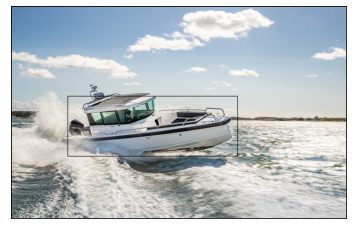

In [39]:
# Loop through the input batch and model outputs
for img_int, output in zip(sample_batch, outputs):
  idxs = output['scores'] > score_threshold

# to get the final boxes
  boxes = torchvision.ops.nms(boxes = output['boxes'][idxs], 
                            scores = output['scores'][idxs], 
                            iou_threshold = 0.5)
  boxes_idxes = boxes.tolist()
  # Call the 'show_nms_boxes"
  show_nms_boxes(sample_batch, outputs, score_threshold)

In [46]:
# Download the image file from the URL and save it as 'image.jpeg'
file_name = 'image.jpeg'
!wget -O $file_name https://i.ytimg.com/vi/jNj7wshXZdU/hqdefault.jpg

--2023-02-01 05:58:40--  https://i.ytimg.com/vi/jNj7wshXZdU/hqdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 142.251.10.119, 142.251.12.119, 172.217.194.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|142.251.10.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13622 (13K) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>]  13.30K  --.-KB/s    in 0s      

2023-02-01 05:58:40 (96.3 MB/s) - ‘image.jpeg’ saved [13622/13622]



In [47]:
sample_img = read_image(file_name)

sample_batch = torch.stack([sample_img])

# Convert the image tensor to the float type and move it to the device (GPU)
batch = convert_image_dtype(sample_batch, dtype=torch.float).to(device)

model = model.eval()

outputs = model(batch)
# Set a score threshold to determine whether to keep or discard predictions
score_threshold = 0.5

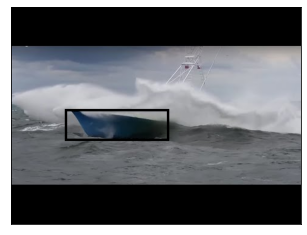

In [48]:
# Loop through the input batch and model outputs
for img_int, output in zip(sample_batch, outputs):
  idxs = output['scores'] > score_threshold

  # to get the final boxes
  boxes = torchvision.ops.nms(boxes = output['boxes'][idxs], 
                            scores = output['scores'][idxs], 
                            iou_threshold = 0.3)
  boxes_idxes = boxes.tolist()
  
  # Call the 'show_nms_boxes"
  show_nms_boxes(sample_batch, outputs, score_threshold)

In [43]:
# Download the image file from the URL and save it as 'image.jpeg'
file_name = 'image.jpeg'
!wget -O $file_name https://www.transatjacquesvabre.org/medias/01/36/13683/image-c-1180-664.jpg

--2023-02-01 05:37:08--  https://www.transatjacquesvabre.org/medias/01/36/13683/image-c-1180-664.jpg
Resolving www.transatjacquesvabre.org (www.transatjacquesvabre.org)... 78.109.85.41
Connecting to www.transatjacquesvabre.org (www.transatjacquesvabre.org)|78.109.85.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242637 (237K) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>] 236.95K   396KB/s    in 0.6s    

2023-02-01 05:37:10 (396 KB/s) - ‘image.jpeg’ saved [242637/242637]



In [44]:
sample_img = read_image(file_name)

sample_batch = torch.stack([sample_img])
# Convert the image tensor to the float type and move it to the device (GPU)
batch = convert_image_dtype(sample_batch, dtype=torch.float).to(device)

model = model.eval()

outputs = model(batch)
# Set a score threshold to determine whether to keep or discard predictions
score_threshold = 0.5

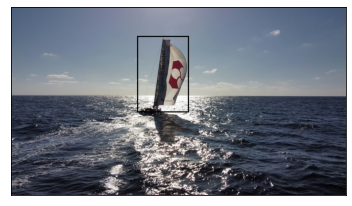

In [45]:
# Loop through the input batch and model outputs
for img_int, output in zip(sample_batch, outputs):
  idxs = output['scores'] > score_threshold
    # to get the final boxes
  boxes = torchvision.ops.nms(boxes = output['boxes'][idxs], 
                            scores = output['scores'][idxs], 
                            iou_threshold = 0.5)
  boxes_idxes = boxes.tolist()
  # Call the 'show_nms_boxes"
  show_nms_boxes(sample_batch, outputs, score_threshold)

I think yes, I have a good accuracy in different weather, but to improve the accuarcy we should 1- Collect images of objects in different weather conditions, such as clear skies, rain, snow. This would help the model learn to recognize objects in a wide range of weather conditions. 2- Increase the number of images 3- Ensure that the dataset contains a balanced distribution of images in different weather conditions to avoid overfitting to a specific weather condition. 4- Include images of objects captured from different angles, distances, and in different lighting conditions to help the model learn to recognize objects in a wide range of scenarios.



## Optional Exercise 10: Train another model of your choice

To go deeper with object detection, you can try different models. A list of all available models is accessible in the [model zoo](https://pytorch.org/vision/stable/models.html).

Do a benchmark of the three models used so far.  
What is the best accuracy ? best speed ? ...